### 1. Problem statement  
 - We are tasked by a Fintech firm to analyze mobile app behavior data to identify potential churn customers.   
 - The goal is to predict which users are likely to churn, so the firm can focus on re-engaging these users with better products.
 - Below is focusing on modelling.

### 2. Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### 3. Data process

In [2]:
dataset = pd.read_csv('new_churn_data.csv')

In [3]:
## Data Preparation
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])

#### 3.1 One-hot encoding

In [4]:
dataset.housing.value_counts()

na    13856
R     10969
O      2171
Name: housing, dtype: int64

In [5]:
dataset.groupby('housing')['churn'].nunique().reset_index()

,housing,churn
0,O,2
1,R,2
2,na,2


In [6]:
dataset = pd.get_dummies(dataset)
dataset.columns

Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtype='object')

#### 3.2 Drop correlated columns (data trap)

In [7]:
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

#### 3.3 Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'),
                                                   dataset['churn'], 
                                                   test_size = 0.2,
                                                   random_state = 0)

#### 3.4 Data balancing

In [9]:
y_train.value_counts()

0    12656
1     8940
Name: churn, dtype: int64

In [10]:
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

#### 3.5 Feature scaling

In [11]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))

In [12]:
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [13]:
X_train.head()

,age,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,cc_liked,cc_application_begin,...,zodiac_sign_Cancer,zodiac_sign_Capricorn,zodiac_sign_Gemini,zodiac_sign_Leo,zodiac_sign_Libra,zodiac_sign_Pisces,zodiac_sign_Sagittarius,zodiac_sign_Scorpio,zodiac_sign_Taurus,zodiac_sign_Virgo
11695,-0.620123,-0.356148,-0.277428,-0.578423,-0.356045,-0.173704,-0.919345,-0.060761,-0.070073,-0.576903,...,-0.309282,-0.161044,-0.29752,-0.313174,-0.294839,-0.291238,-0.291012,-0.287493,-0.298743,-0.315108
19766,-0.419529,-0.356148,-0.277428,-0.625811,-0.356045,-0.173704,0.307991,1.012763,-0.070073,-0.576903,...,-0.309282,-0.161044,-0.29752,-0.313174,3.391680,-0.291238,-0.291012,-0.287493,-0.298743,-0.315108
8354,0.282547,-0.356148,-0.277428,-0.625811,-0.356045,-0.173704,1.989896,-0.060761,-0.070073,-0.253821,...,-0.309282,-0.161044,-0.29752,-0.313174,-0.294839,-0.291238,-0.291012,-0.287493,-0.298743,3.173517
17883,0.583437,-0.356148,-0.277428,0.037622,-0.356045,-0.173704,-0.192034,-0.060761,-0.070073,-0.011510,...,-0.309282,-0.161044,-0.29752,-0.313174,-0.294839,-0.291238,-0.291012,-0.287493,3.347354,-0.315108
25149,-0.820716,-0.244592,-0.277428,-0.104543,-0.242127,-0.173704,-0.589782,-0.060761,-0.070073,-0.253821,...,-0.309282,-0.161044,-0.29752,-0.313174,-0.294839,3.433613,-0.291012,-0.287493,-0.298743,-0.315108


### 4. Model create

#### 4.1 Create model

In [14]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [15]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [16]:
# Evaluating Results
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.6125925925925926

In [17]:
precision_score(y_test, y_pred) # tp / (tp + fp)

0.5223551637279596

In [18]:
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7426141450313339

In [19]:
f1_score(y_test, y_pred)

0.6133086876155268

Test Data Accuracy: 0.6126


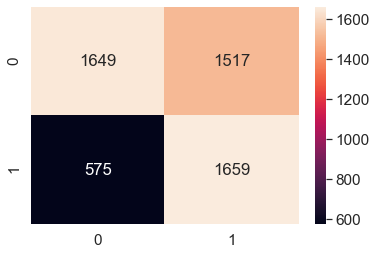

In [20]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (6,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

#### 4.2 Cross Validation

In [21]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [22]:
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

Accuracy: 0.646 (+/- 0.020)


In [23]:
accuracies.mean()

0.6462527964205816

In [24]:
len(X_train.columns.tolist())

41

#### 4.3 Feature importance analysis

In [25]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.172233
1,deposits,0.249512
2,withdrawal,0.050471
3,purchases_partners,-0.739438
4,purchases,-0.378188
5,cc_taken,0.037478
6,cc_recommended,0.076087
7,cc_disliked,-0.018237
8,cc_liked,0.023462
9,cc_application_begin,0.021110


#### 4.4 Feature Selection

In [26]:
# Model to Test
classifier = LogisticRegression()
# Select Best X Features
rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)

#### summarize the selection of the attributes

In [27]:
print(rfe.support_)

[ True  True  True  True  True  True  True False False False False  True
  True False  True False  True  True  True  True  True  True False False
  True  True False False  True False False False False  True False False
 False False False False False]


In [28]:
print(rfe.ranking_)

[ 1  1  1  1  1  1  1 13 10 12  5  1  1  4  1  3  1  1  1  1  1  1 17 11
  1  1 18 14  1  2 19 22 16  1  7  8 15  9 21  6 20]


In [29]:
X_train.columns[rfe.support_]

Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_recommended', 'web_user', 'ios_user',
       'registered_phones', 'cancelled_loan', 'received_loan', 'rejected_loan',
       'left_for_two_month_plus', 'left_for_one_month', 'reward_rate',
       'housing_R', 'payment_type_Bi-Weekly', 'payment_type_Weekly',
       'zodiac_sign_Gemini'],
      dtype='object')

#### 4.5 Retrain model

In [30]:
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

LogisticRegression()

In [31]:
# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

In [32]:
# Evaluating Results
cm = confusion_matrix(y_test, y_pred)

In [33]:
accuracy_score(y_test, y_pred)

0.6087037037037037

In [34]:
f1_score(y_test, y_pred)

0.6107938846933136

Test Data Accuracy: 0.6087


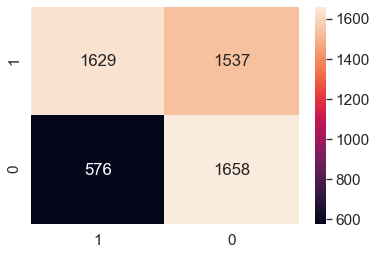

In [35]:
df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (6,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

#### 4.6 Cross validation (2nd)

In [36]:
# Applying k-Fold Cross Validation
# Fitting Model to the Training Set

accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)


In [37]:
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

Accuracy: 0.644 (+/- 0.019)


#### 4.7 Feature importance analysis (2nd)

In [38]:
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ], axis = 1)

,features,coef
0,age,-0.169790
1,deposits,0.264277
2,withdrawal,0.051066
3,purchases_partners,-0.744367
4,purchases,-0.389585
5,cc_taken,0.039974
6,cc_recommended,0.087737
7,web_user,0.152914
8,ios_user,0.080673
9,registered_phones,0.088488


In [39]:
y_test

2834     1
21018    0
5590     0
15769    0
15120    0
        ..
16090    1
9851     0
654      1
26248    1
10769    0
Name: churn, Length: 5400, dtype: int64

In [40]:
user_identifier

0        55409
1        23547
2        58313
3         8095
4        61353
         ...  
26991    24291
26992     4116
26993    23740
26994    47663
26995    52752
Name: user, Length: 26996, dtype: int64

#### 4.8 Formatting Final Results

In [41]:
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)

In [42]:
final_results

,user,churn,predicted_churn
0,61353,1.0,0
1,67679,0.0,0
2,21269,0.0,0
3,69531,0.0,1
4,25997,0.0,0
...,...,...,...
5395,22377,0.0,1
5396,24291,1.0,1
5397,23740,0.0,1
5398,47663,1.0,0
